# Week 4

In this project, I will find out the best neighborhood in Toronto for entrepreneurs to open a new Italian Restaurant by
- using multiple datasets from different sources
- python webscraping using beautifulsoup
- data preprocessing
- data analysis

In [1]:
# import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import requests
import json
from bs4 import BeautifulSoup
import matplotlib.cm as cm
import matplotlib.colors as colors

print("packages installed")

packages installed


In [2]:
# get teh neighborhood data using beautiful soup
url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
result = requests.get(url)
data_html = BeautifulSoup(result.content)

In [3]:
# now we will read the data into a pnadas datframe
soup = BeautifulSoup(str(data_html))
neigh = soup.find('table')
table_str = str(neigh.extract())

In [4]:
df = pd.read_html(table_str)[0]
df.head()

,Postal Code,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"


we see that there are not assigned borough so we will revmove these

In [5]:
df_dropna = df[df.Borough != 'Not assigned'].reset_index(drop=True)

In [6]:
df_dropna.rename(columns={'Postal Code':'PostalCode'},inplace=True)

In [7]:
df = df_dropna

In [8]:
df.head()

,PostalCode,Borough,Neighbourhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


Now we will group the data based on Borough

In [9]:
df_grouped = df.groupby(['Borough','PostalCode'], as_index=False).agg(lambda x:','.join(x))
df_grouped.head()

,Borough,PostalCode,Neighbourhood
0,Central Toronto,M4N,Lawrence Park
1,Central Toronto,M4P,Davisville North
2,Central Toronto,M4R,"North Toronto West, Lawrence Park"
3,Central Toronto,M4S,Davisville
4,Central Toronto,M4T,"Moore Park, Summerhill East"


In [10]:
# check if we still have any neighborhoods taht are not assigned
df_grouped.loc[df_grouped['Borough'].isin(["Not assigned"])]

,Borough,PostalCode,Neighbourhood


In [11]:
df = df_grouped

In [12]:
df.shape

(103, 3)

Rearrange the columns so the PostalCode appears first for easier readibility

In [13]:
df = df[['PostalCode','Borough','Neighbourhood']]

In [14]:
df.head()

,PostalCode,Borough,Neighbourhood
0,M4N,Central Toronto,Lawrence Park
1,M4P,Central Toronto,Davisville North
2,M4R,Central Toronto,"North Toronto West, Lawrence Park"
3,M4S,Central Toronto,Davisville
4,M4T,Central Toronto,"Moore Park, Summerhill East"


Now we are going to create a new table with the Latitudes adn longitudes corresponding to different postalcodes

In [15]:
geo_url = "https://cocl.us/Geospatial_data"

geo_df = pd.read_csv(geo_url)
geo_df.rename(columns={'Postal Code': 'PostalCode'},inplace=True)
geo_df.head()

,PostalCode,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


Now we will merge the data. We will make the actual data equal to the temporary data frame we are working with because we are happy with it then we will merge it based ont eh postal code. 

In [16]:
# marge the data
df = pd.merge(df,geo_df,on='PostalCode')

In [17]:
df.head()

,PostalCode,Borough,Neighbourhood,Latitude,Longitude
0,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790
1,M4P,Central Toronto,Davisville North,43.712751,-79.390197
2,M4R,Central Toronto,"North Toronto West, Lawrence Park",43.715383,-79.405678
3,M4S,Central Toronto,Davisville,43.704324,-79.388790
4,M4T,Central Toronto,"Moore Park, Summerhill East",43.689574,-79.383160


In [18]:
# lets find out how many neighborhoods in each borough
df.groupby('Borough').count()['Neighbourhood']

Borough
Central Toronto      9
Downtown Toronto    19
East Toronto         5
East York            5
Etobicoke           12
Mississauga          1
North York          24
Scarborough         17
West Toronto         6
York                 5
Name: Neighbourhood, dtype: int64

Now we will find all neighbourhoods that have Toronto in it

In [19]:
df_toronto = df
df_toronto.head()

,PostalCode,Borough,Neighbourhood,Latitude,Longitude
0,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790
1,M4P,Central Toronto,Davisville North,43.712751,-79.390197
2,M4R,Central Toronto,"North Toronto West, Lawrence Park",43.715383,-79.405678
3,M4S,Central Toronto,Davisville,43.704324,-79.388790
4,M4T,Central Toronto,"Moore Park, Summerhill East",43.689574,-79.383160


In [20]:
# create list with the boroughs (to be used later)
boroughs = df_toronto['Borough'].unique().tolist()

In [21]:
# obtain the coordinates from the dataset itself, just averaging latitude/longitude of the current dataset
lat_toronto = df_toronto['Latitude'].mean()
lon_toronto = df_toronto['Longitude'].mean()
print('The geographical coordinates of Toronto are {},{}'.format(lat_toronto,lon_toronto))

The geographical coordinates of Toronto are 43.70460773398059,-79.39715291165047


In [22]:
# This will color categorize each borough
borough_color = {}
for borough in boroughs:
    borough_color[borough]='#%02X%02X%02X' % tuple(np.random.choice(range(256), size=3)) #Random color

In [23]:
map_toronto = folium.Map(location=[lat_toronto, lon_toronto], zoom_start=10.5)

# add markers to map
for lat, lng, borough, neighborhood in zip(df_toronto['Latitude'], 
                                           df_toronto['Longitude'],
                                           df_toronto['Borough'], 
                                           df_toronto['Neighbourhood']):
    label_text = borough + ' - ' + neighborhood
    label = folium.Popup(label_text)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=borough_color[borough],
        fill_color=borough_color[borough],
        fill_opacity=0.8).add_to(map_toronto)  
    
map_toronto

Next we will define foursquare credentials

In [24]:
CLIENT_ID = 'HSRK10QSSA13F2O4AQ3PPYOHDZTOTJC4O1NYSSUA0K5GRGDD' # your Foursquare ID
CLIENT_SECRET = 'GHUXGULRGW0NSPNZAOCOQK1TS4JSIAIQDBNMMCHFPZFOEXG3' # your Foursquare Secret
VERSION = '20201010'

print('credentials stored')

credentials stored


Now let's get the top 100 venues that are in Lawrence Park within a radius of 500 meters. 

In [25]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    LIMIT = 100 # limit of number of venues returned by Foursquare API
    radius = 500 # define radius
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
        
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [26]:
#Get venues for all neighborhoods in our dataset
toronto_venues = getNearbyVenues(names=df_toronto['Neighbourhood'],
                                latitudes=df_toronto['Latitude'],
                                longitudes=df_toronto['Longitude'])

Lawrence Park
Davisville North
North Toronto West, Lawrence Park
Davisville
Moore Park, Summerhill East
Summerhill West, Rathnelly, South Hill, Forest Hill SE, Deer Park
Roselawn
Forest Hill North & West, Forest Hill Road Park
The Annex, North Midtown, Yorkville
Rosedale
St. James Town, Cabbagetown
Church and Wellesley
Regent Park, Harbourfront
Garden District, Ryerson
St. James Town
Berczy Park
Central Bay Street
Richmond, Adelaide, King
Harbourfront East, Union Station, Toronto Islands
Toronto Dominion Centre, Design Exchange
Commerce Court, Victoria Hotel
University of Toronto, Harbord
Kensington Market, Chinatown, Grange Park
CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport
Stn A PO Boxes
First Canadian Place, Underground city
Christie
Queen's Park, Ontario Provincial Government
The Beaches
The Danforth West, Riverdale
India Bazaar, The Beaches West
Studio District
Business reply mail Processing Centre, South Central Letter 

In [27]:
toronto_venues.head()

,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Lawrence Park,43.728020,-79.388790,Lawrence Park Ravine,43.726963,-79.394382,Park
1,Lawrence Park,43.728020,-79.388790,Zodiac Swim School,43.728532,-79.382860,Swim School
2,Lawrence Park,43.728020,-79.388790,TTC Bus #162 - Lawrence-Donway,43.728026,-79.382805,Bus Line
3,Davisville North,43.712751,-79.390197,Homeway Restaurant & Brunch,43.712641,-79.391557,Breakfast Spot
4,Davisville North,43.712751,-79.390197,Sherwood Park,43.716551,-79.387776,Park


In [28]:
# Lets check how mnay venues per neighborhood
toronto_venues.groupby('Neighbourhood').count()

,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighbourhood,,,,,,
Agincourt,5,5,5,5,5,5
"Alderwood, Long Branch",7,7,7,7,7,7
"Bathurst Manor, Wilson Heights, Downsview North",21,21,21,21,21,21
Bayview Village,4,4,4,4,4,4
"Bedford Park, Lawrence Manor East",22,22,22,22,22,22
...,...,...,...,...,...,...
"Willowdale, Willowdale West",5,5,5,5,5,5
Woburn,4,4,4,4,4,4
Woodbine Heights,8,8,8,8,8,8


How many unique venues are there?

In [29]:
print("There are {} uniques categories.".format(len(toronto_venues['Venue Category'].unique())))

There are 274 uniques categories.


In [30]:
print("The Venue Categories are", toronto_venues['Venue Category'].unique())

The Venue Categories are ['Park' 'Swim School' 'Bus Line' 'Breakfast Spot' 'Food & Drink Shop'
 'Department Store' 'Hotel' 'Sandwich Place' 'Gym / Fitness Center'
 'Dog Run' 'Dance Studio' 'Yoga Studio' 'Diner' 'Salon / Barbershop'
 'Restaurant' 'Clothing Store' 'Spa' 'Mexican Restaurant' 'Coffee Shop'
 'Chinese Restaurant' 'Sporting Goods Shop' 'Fast Food Restaurant' 'Café'
 'Ice Cream Shop' 'Furniture / Home Store' 'Bagel Shop' 'Dessert Shop'
 'Indian Restaurant' 'Pizza Place' 'Seafood Restaurant'
 'Italian Restaurant' 'Sushi Restaurant' 'Thai Restaurant' 'Brewery' 'Gym'
 'Toy / Game Store' 'Greek Restaurant' 'Gas Station' 'Farmers Market'
 'Gourmet Shop' 'Pharmacy' 'Indoor Play Area' 'Trail' 'Playground'
 'Liquor Store' 'Supermarket' 'American Restaurant' 'Pub'
 'Fried Chicken Joint' 'Bank' 'Vietnamese Restaurant' 'Light Rail Station'
 'Garden' 'Music Venue' 'Jewelry Store' 'Middle Eastern Restaurant'
 'BBQ Joint' 'Donut Shop' 'Burger Joint' 'History Museum'
 'Japanese Restaurant' '

Are there any Chines restruarants in the venues?

In [31]:
"Chinese Restaurant" in toronto_venues['Venue Category'].unique()

True

Now we will analyze each neighborhood

In [32]:
# one hot encoding
to_onehot = pd.get_dummies(toronto_venues[['Venue Category']],prefix="",prefix_sep="")

# add neighborhood column back to dataframe
to_onehot['Neighbourhoods'] = toronto_venues['Neighbourhood']

# move neighborhood column to the first column
fixed_columns = [to_onehot.columns[-1]] + list(to_onehot.columns[:-1])
to_onehot = to_onehot[fixed_columns]

print(to_onehot.shape)
to_onehot.head()

(2139, 275)


,Neighbourhoods,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,...,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,Lawrence Park,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Lawrence Park,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Lawrence Park,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Davisville North,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Davisville North,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [33]:
to_grouped = to_onehot.groupby(["Neighbourhoods"]).mean().reset_index()

print(to_grouped.shape)
to_grouped.head()

(96, 275)


,Neighbourhoods,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,...,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,Agincourt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,"Alderwood, Long Branch",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,"Bathurst Manor, Wilson Heights, Downsview North",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Bayview Village,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,"Bedford Park, Lawrence Manor East",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.045455,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [34]:
chinesefood = to_grouped[["Neighbourhoods","Chinese Restaurant"]]
chinesefood.head() #.head() shows the first five rows only

,Neighbourhoods,Chinese Restaurant
0,Agincourt,0.000000
1,"Alderwood, Long Branch",0.000000
2,"Bathurst Manor, Wilson Heights, Downsview North",0.047619
3,Bayview Village,0.250000
4,"Bedford Park, Lawrence Manor East",0.000000


In [35]:
chinesefood = chinesefood.rename(columns={'Neighbourhoods':'Neighbourhood'})

Now we will cluster the neighbourhoods
we will use k-means clustering. but first we will find the best K using teh Elbow Point method.

In [36]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters = 3, init = 'k-means++',max_iter=15, random_state=8)
X = chinesefood.drop(['Neighbourhood'],axis=1)

In [37]:
kmeans.fit(X)
kmeans.labels_[0:10]

array([0, 0, 2, 1, 0, 0, 0, 0, 0, 0])

In [38]:
def get_inertia(n_clusters):
    km = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=15, random_state=8)
    km.fit(X)
    return km.inertia_

In [39]:
scores = [get_inertia(x) for x in range(2, 21)]

C:\Program Files\Python\lib\site-packages\ipykernel_launcher.py:3: ConvergenceWarning: Number of distinct clusters (13) found smaller than n_clusters (14). Possibly due to duplicate points in X.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Program Files\Python\lib\site-packages\ipykernel_launcher.py:3: ConvergenceWarning: Number of distinct clusters (13) found smaller than n_clusters (15). Possibly due to duplicate points in X.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Program Files\Python\lib\site-packages\ipykernel_launcher.py:3: ConvergenceWarning: Number of distinct clusters (13) found smaller than n_clusters (16). Possibly due to duplicate points in X.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Program Files\Python\lib\site-packages\ipykernel_launcher.py:3: ConvergenceWarning: Number of distinct clusters (13) found smaller than n_clusters (17). Possibly due 

Text(0, 0.5, 'Error')

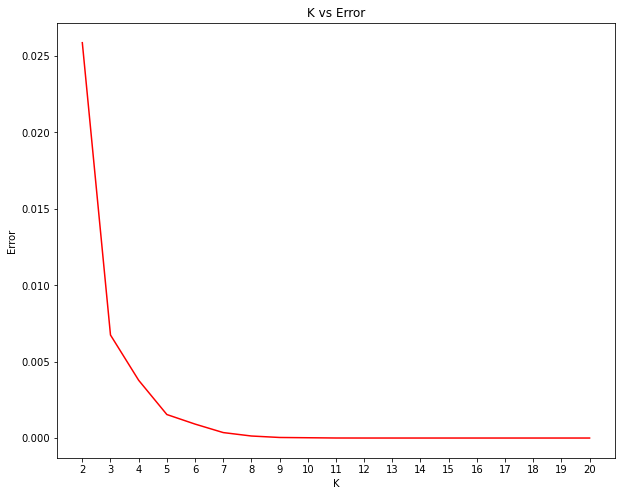

In [40]:
plt.figure(figsize=[10, 8])
sns.lineplot(x=range(2, 21), y=scores, color='r')
plt.title("K vs Error")
plt.xticks(range(2, 21))
plt.xlabel("K")
plt.ylabel("Error")

In [47]:
kclusters = 4

toronto_grouped_clustering = chinesefood.drop('Neighbourhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([0, 0, 2, 1, 0, 0, 0, 0, 0, 0])

In [49]:
# create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.
to_merged = chinesefood.copy()

# add clustering labels
to_merged["Cluster Labels"] = kmeans.labels_

In [50]:
to_merged.head()

,Neighbourhood,Chinese Restaurant,Cluster Labels
0,Agincourt,0.000000,0
1,"Alderwood, Long Branch",0.000000,0
2,"Bathurst Manor, Wilson Heights, Downsview North",0.047619,2
3,Bayview Village,0.250000,1
4,"Bedford Park, Lawrence Manor East",0.000000,0


In [53]:
# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
to_merged = to_merged.join(toronto_venues.set_index("Neighbourhood"), on="Neighbourhood")

print(to_merged.shape)
to_merged.head()

(2139, 9)


,Neighbourhood,Chinese Restaurant,Cluster Labels,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Agincourt,0.0,0,43.7942,-79.262029,Panagio's Breakfast & Lunch,43.792370,-79.260203,Breakfast Spot
0,Agincourt,0.0,0,43.7942,-79.262029,El Pulgarcito,43.792648,-79.259208,Latin American Restaurant
0,Agincourt,0.0,0,43.7942,-79.262029,Twilight,43.791999,-79.258584,Lounge
0,Agincourt,0.0,0,43.7942,-79.262029,Mark's,43.791179,-79.259714,Clothing Store
0,Agincourt,0.0,0,43.7942,-79.262029,Commander Arena,43.794867,-79.267989,Skating Rink


In [54]:
# sort the results by Cluster Labels
print(to_merged.shape)
to_merged.sort_values(["Cluster Labels"], inplace=True)
to_merged

(2139, 9)


,Neighbourhood,Chinese Restaurant,Cluster Labels,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Agincourt,0.000000,0,43.794200,-79.262029,Panagio's Breakfast & Lunch,43.792370,-79.260203,Breakfast Spot
64,"Richmond, Adelaide, King",0.000000,0,43.650571,-79.384568,JaBistro,43.649687,-79.388090,Sushi Restaurant
64,"Richmond, Adelaide, King",0.000000,0,43.650571,-79.384568,Friendly Stranger - Cannabis Culture Shop,43.650387,-79.388523,Smoke Shop
64,"Richmond, Adelaide, King",0.000000,0,43.650571,-79.384568,Cactus Club Cafe,43.649552,-79.381671,American Restaurant
64,"Richmond, Adelaide, King",0.000000,0,43.650571,-79.384568,Pizzeria Libretto,43.648334,-79.385111,Pizza Place
...,...,...,...,...,...,...,...,...,...
23,"Dorset Park, Wexford Heights, Scarborough Town...",0.200000,3,43.757410,-79.273304,Kairali,43.754915,-79.276945,Indian Restaurant
23,"Dorset Park, Wexford Heights, Scarborough Town...",0.200000,3,43.757410,-79.273304,Pho Vietnam,43.757770,-79.278572,Vietnamese Restaurant
23,"Dorset Park, Wexford Heights, Scarborough Town...",0.200000,3,43.757410,-79.273304,Kim Kim restaurant,43.753833,-79.276611,Chinese Restaurant
87,Westmount,0.166667,3,43.696319,-79.532242,Subway,43.692927,-79.531471,Sandwich Place


In [55]:
to_merged['Venue Category'].value_counts()['Chinese Restaurant']

16

In [57]:
# create map
map_clusters = folium.Map(location=[lat_toronto, lon_toronto], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(to_merged['Neighbourhood Latitude'], to_merged['Neighbourhood Longitude'], to_merged['Neighbourhood'], to_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' - Cluster ' + str(cluster))
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill_color=rainbow[cluster-1],
        fill_opacity=0.8).add_to(map_clusters)
       
map_clusters

In [58]:
chinesefood["Cluster Labels"] = kmeans.labels_
chinesefood.head()

,Neighbourhood,Chinese Restaurant,Cluster Labels
0,Agincourt,0.000000,0
1,"Alderwood, Long Branch",0.000000,0
2,"Bathurst Manor, Wilson Heights, Downsview North",0.047619,2
3,Bayview Village,0.250000,1
4,"Bedford Park, Lawrence Manor East",0.000000,0


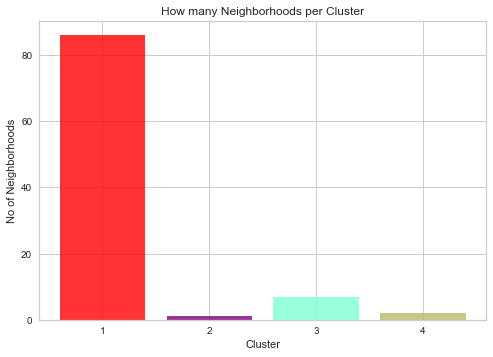

In [60]:
objects = (1,2,3,4)
y_pos = np.arange(len(objects))
performance = chinesefood['Cluster Labels'].value_counts().to_frame().sort_index(ascending=True)
perf = performance['Cluster Labels'].tolist()
plt.bar(y_pos, perf, align='center', alpha=0.8, color=['red', 'purple','aquamarine', 'darkkhaki'])
plt.xticks(y_pos, objects)
plt.ylabel('No of Neighborhoods')
plt.xlabel('Cluster')
plt.title('How many Neighborhoods per Cluster')

plt.show()

In [62]:

# How many neighborhoods in each cluster
chinesefood['Cluster Labels'].value_counts()

0    86
2     7
3     2
1     1
Name: Cluster Labels, dtype: int64

### Analysis of each cluster

In [64]:
# This will create a dataframe with borough of each neighborhood which we will merge with each cluster dataframe
df_new = df[['Borough', 'Neighbourhood']]
df_new.head()

,Borough,Neighbourhood
0,Central Toronto,Lawrence Park
1,Central Toronto,Davisville North
2,Central Toronto,"North Toronto West, Lawrence Park"
3,Central Toronto,Davisville
4,Central Toronto,"Moore Park, Summerhill East"


In [66]:
# Red 

cluster1 = to_merged.loc[to_merged['Cluster Labels'] == 0]
df_cluster1 = pd.merge(df_new, cluster1, on='Neighbourhood')
df_cluster1

,Borough,Neighbourhood,Chinese Restaurant,Cluster Labels,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Central Toronto,Lawrence Park,0.0,0,43.728020,-79.388790,Lawrence Park Ravine,43.726963,-79.394382,Park
1,Central Toronto,Lawrence Park,0.0,0,43.728020,-79.388790,Zodiac Swim School,43.728532,-79.382860,Swim School
2,Central Toronto,Lawrence Park,0.0,0,43.728020,-79.388790,TTC Bus #162 - Lawrence-Donway,43.728026,-79.382805,Bus Line
3,Central Toronto,Davisville North,0.0,0,43.712751,-79.390197,Sherwood Park,43.716551,-79.387776,Park
4,Central Toronto,Davisville North,0.0,0,43.712751,-79.390197,Love To Dance,43.708387,-79.390558,Dance Studio
...,...,...,...,...,...,...,...,...,...,...
2000,York,"Runnymede, The Junction North",0.0,0,43.673185,-79.487262,Wonderfood,43.672352,-79.492571,Convenience Store
2001,York,"Runnymede, The Junction North",0.0,0,43.673185,-79.487262,High Park Brewery,43.669903,-79.483430,Brewery
2002,York,"Runnymede, The Junction North",0.0,0,43.673185,-79.487262,Starving Artist,43.669860,-79.483110,Breakfast Spot
2003,York,Weston,0.0,0,43.706876,-79.518188,Wallace C. Swanek Park,43.708896,-79.522648,Park


In [67]:
# Purple 
cluster2=to_merged.loc[to_merged['Cluster Labels'] == 1]
df_cluster2 = pd.merge(df_new, cluster2, on='Neighbourhood')

In [68]:
df_cluster2.sort_values(["Chinese Restaurant"], ascending=False)

,Borough,Neighbourhood,Chinese Restaurant,Cluster Labels,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,North York,Bayview Village,0.25,1,43.786947,-79.385975,Sun Star Chinese Cuisine 翠景小炒,43.787914,-79.381234,Chinese Restaurant
1,North York,Bayview Village,0.25,1,43.786947,-79.385975,TD Canada Trust,43.788074,-79.380367,Bank
2,North York,Bayview Village,0.25,1,43.786947,-79.385975,Maxim's Cafe and Patisserie,43.787863,-79.380751,Café
3,North York,Bayview Village,0.25,1,43.786947,-79.385975,Kaga Sushi,43.787758,-79.381090,Japanese Restaurant


In [69]:
df_cluster2['Venue Category'].value_counts(ascending=False)['Chinese Restaurant']

1

In [70]:
# Blue
cluster3 = to_merged.loc[to_merged['Cluster Labels'] == 2]
df_cluster3 = pd.merge(df_new, cluster3, on='Neighbourhood')
df_cluster3

,Borough,Neighbourhood,Chinese Restaurant,Cluster Labels,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Central Toronto,"North Toronto West, Lawrence Park",0.055556,2,43.715383,-79.405678,The Bagel House,43.714004,-79.399953,Bagel Shop
1,Central Toronto,"North Toronto West, Lawrence Park",0.055556,2,43.715383,-79.405678,Degrees Kitchen Store,43.714307,-79.399882,Furniture / Home Store
2,Central Toronto,"North Toronto West, Lawrence Park",0.055556,2,43.715383,-79.405678,Milkcow,43.715907,-79.400125,Ice Cream Shop
3,Central Toronto,"North Toronto West, Lawrence Park",0.055556,2,43.715383,-79.405678,St. Clements - Yonge Parkette,43.712062,-79.404255,Park
4,Central Toronto,"North Toronto West, Lawrence Park",0.055556,2,43.715383,-79.405678,Second Cup,43.714583,-79.400120,Café
...,...,...,...,...,...,...,...,...,...,...
185,Scarborough,"Steeles West, L'Amoreaux West",0.083333,2,43.799525,-79.318389,Price Chopper,43.799445,-79.318563,Grocery Store
186,Scarborough,"Steeles West, L'Amoreaux West",0.083333,2,43.799525,-79.318389,KFC,43.798938,-79.318854,Fast Food Restaurant
187,Scarborough,"Steeles West, L'Amoreaux West",0.083333,2,43.799525,-79.318389,Subway,43.798671,-79.318475,Sandwich Place
188,Scarborough,"Steeles West, L'Amoreaux West",0.083333,2,43.799525,-79.318389,Mr Congee Chinese Cuisine 龍粥記,43.798879,-79.318335,Chinese Restaurant


In [71]:
# Turquoise
cluster4 = to_merged.loc[to_merged['Cluster Labels'] == 3]
df_cluster4 = pd.merge(df_new, cluster4, on='Neighbourhood')
df_cluster4

,Borough,Neighbourhood,Chinese Restaurant,Cluster Labels,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Etobicoke,Westmount,0.166667,3,43.696319,-79.532242,Mayflower Chinese Food,43.692753,-79.531566,Chinese Restaurant
1,Etobicoke,Westmount,0.166667,3,43.696319,-79.532242,Pizza Hut,43.696431,-79.533233,Pizza Place
2,Etobicoke,Westmount,0.166667,3,43.696319,-79.532242,Dollarama,43.691945,-79.531593,Discount Store
3,Etobicoke,Westmount,0.166667,3,43.696319,-79.532242,Dixon & Royal York,43.700013,-79.534408,Intersection
4,Etobicoke,Westmount,0.166667,3,43.696319,-79.532242,Subway,43.692927,-79.531471,Sandwich Place
5,Etobicoke,Westmount,0.166667,3,43.696319,-79.532242,Starbucks,43.696338,-79.533398,Coffee Shop
6,Scarborough,"Dorset Park, Wexford Heights, Scarborough Town...",0.200000,3,43.757410,-79.273304,Karaikudi Chettinad South Indian Restaurant,43.756042,-79.276276,Indian Restaurant
7,Scarborough,"Dorset Park, Wexford Heights, Scarborough Town...",0.200000,3,43.757410,-79.273304,Big Al's Pet Supercentre,43.759279,-79.278325,Pet Store
8,Scarborough,"Dorset Park, Wexford Heights, Scarborough Town...",0.200000,3,43.757410,-79.273304,Kairali,43.754915,-79.276945,Indian Restaurant
9,Scarborough,"Dorset Park, Wexford Heights, Scarborough Town...",0.200000,3,43.757410,-79.273304,Pho Vietnam,43.757770,-79.278572,Vietnamese Restaurant


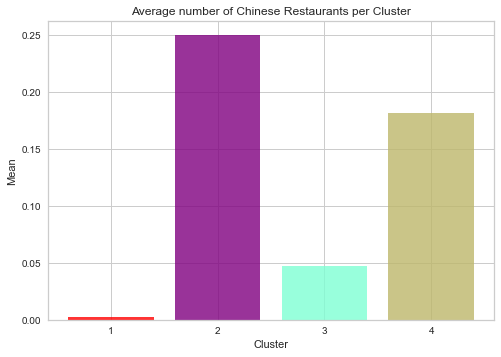

In [72]:
clusters_mean = [df_cluster1['Chinese Restaurant'].mean(),df_cluster2['Chinese Restaurant'].mean(),df_cluster3['Chinese Restaurant'].mean(),
                 df_cluster4['Chinese Restaurant'].mean()]
objects = (1,2,3,4)
y_pos = np.arange(len(objects))
perf = clusters_mean
plt.bar(y_pos, perf, align='center', alpha=0.8, color=['red', 'purple','aquamarine', 'darkkhaki'])
plt.xticks(y_pos, objects)
plt.ylabel('Mean')
plt.xlabel('Cluster')
plt.title('Average number of Chinese Restaurants per Cluster')

plt.show()


Most of the Chinese Restaurants are in cluster 2 represented by the purple clusters. 